In [ ]:
#### Create Plots based on OSCAR xml files ####
# analysis of specific variables

# used python version 3.10.6

In [26]:
import xml.etree.ElementTree as ET
import urllib.request
import csv
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import json
import re
import os
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
import matplotlib.lines as mlines
from urllib.request import urlopen
from bs4 import BeautifulSoup
import datetime
from functools import reduce
from datetime import date


In [2]:
id = "0-20000-0-63772"

In [3]:
def get_xml_info(WIGOS_ID):

    """get xml information through jOAI and save file
    """    

    # open xml file thorugh jOAI
    url = "https://oscar.wmo.int/oai/provider?verb=GetRecord&metadataPrefix=wmdr&identifier=%20" + str(id)
    xml = urlopen(url).read()
    soup = BeautifulSoup(xml, 'xml')
    content = soup('OAI-PMH')

    # save file
    with open(os.getcwd()+"/Files/File_"+id+".txt", 'w') as f:
        f.write(str(content))
    

In [ ]:
id = "0-20000-0-63772"
get_xml_info(WIGOS_ID=id)

In [19]:
# define function: find necessary information and create data frame

def get_deployments_station(WIGOS_ID):

    """ create data frame with the required information (station, establishment date and deployment dates) of a specific station 

    Parameters:
        WIGOS_ID (str): WIGOS identifier of the station of interest   

    Returns:
        df_station (data frame): data frame with the required information (start and end dates of deployments, establishment date, etc.)
    """  

    id = WIGOS_ID

    # get xml for the station
    get_xml_info(id)

    # get variables at a station
    url = "https://oscar.wmo.int/oai/provider?verb=GetRecord&metadataPrefix=wmdr&identifier=%20" + str(id)
    xml = urlopen(url).read()
    soup = BeautifulSoup(xml, 'xml')

    # Establishment date of station
    dateEstablished = soup.find_all('dateEstablished')
    if dateEstablished:
        dateEstablished = re.findall(r'\d{4}-\d{2}-\d{2}',str(dateEstablished))[0]
    else: 
        dateEstablished = "unknown"

    # find observed properties
    observedProperties = []
    with open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt') as myFile:
        observedProperties_line = soup.find_all('observedProperty')
        observedProperties_notation = re.findall(r'\d+',str(observedProperties_line))
        observedProperties.append(observedProperties_notation)

    # list of unique observed properties 
    def unique(list1):
        ans = reduce(lambda re, x: re+[x] if x not in re else re, list1, [])
        return(ans)
    variables_u = unique(observedProperties[0])

    # open file
    f=open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt')
    lines=f.readlines()
    all_dates = []

    # prepare data frame 
    df_station = pd.DataFrame(np.nan, index=[0],columns=["beginPosition", "endPosition", "station", "dateEstablished", "variable"])

    # go through every observed variable 
    for var in variables_u:

        # find line numbers containing the WMDR notation of the observed property
        numbers = []

        with open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt') as myFile:
            for num, line in enumerate(myFile, 1):
                if var in line:
                    numbers.append(num)

        # find the line numbers with <om:observedProperty
        obs = "observedProperty"
        numbers_obs = []

        for n in numbers:
            if obs in lines[n-1]:
                number = re.findall(r'\d+',lines[n-1])
                if number[0]==str(var):
                    numbers_obs.append(n)

        # read 50 lines before "observedProperty" line to get "beginPosition" (& "endPosition")
        for n in numbers_obs:
            start = "beginPosition"
            end = "endPosition"
            line_numbers = range(n-50,n)

            f=open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt')
            lines=f.readlines()
            positions = []

            for n in line_numbers:
                if start in lines[n]:
                    beginning = re.findall(r'\d{4}-\d{2}-\d{2}',lines[n])
                    if beginning:
                        pd.to_datetime(beginning, format='%Y-%m-%d')
                        positions.append(beginning[0])
                    else:
                        positions.append(np.nan)
                        
                elif end in lines[n]:
                    ending = re.findall(r'\d{4}-\d{2}-\d{2}',lines[n])
                    if ending:
                        pd.to_datetime(ending, format='%Y-%m-%d')
                        positions.append(ending[0])
                    else: # if no ending: today
                        positions.append(pd.Timestamp.today().strftime("%Y-%m-%d"))

            beginPosition  = positions[0]
            endPosition = positions[1]
            # fill new row to data frame
            new_row = {"beginPosition":beginPosition,"endPosition":endPosition,"station":id, "dateEstablished":dateEstablished, "variable":var}
            df_station.loc[len(df_station)] = new_row 

    # delete row zero from data frame
    df_station.drop([0], axis=0, inplace=True)
    
    # get names of variables through dictionary
    with open(os.getcwd()+'/WMDR_dictionaries/'+'T_GO_VARIABLE_REF_dictionary.json') as f:
        dictionary = json.loads(f.read())
    variables = df_station["variable"]
    df_station["variables_names"] = [(list(dictionary.keys())[list(dictionary.values()).index(str(vari))]) for vari in variables]

    # print data frame
    print(df_station)
    return df_station, variables_u

In [23]:
# define function: create plot showing all deployments registered for a specific station

def plot_deployments_station(WIGOS_ID):

    """ create plot showing all deployments registered for a specific station
    
        Parameters:
        WIGOS_ID (str): WIGOS identifier of the station of interest   
    """       
    id = WIGOS_ID
    df_station,variables_u = get_deployments_station(id)

    # plot
    plt.style.use('default')
    fig, axes = plt.subplots(1,1, figsize=(14,8))
    variables = variables_u
    # plot every deployment
    for var in range(0,len(variables)):
        df_var = df_station[df_station["variable"]==str(variables[var])]
        x_values = [pd.to_datetime(df_var["beginPosition"]), pd.to_datetime(df_var["endPosition"])]
        plt.plot(x_values, [var,var], 'bo', linestyle="--")

    # plot ployment names
    names = []
    for var in range(0,len(variables)):
        variable_df = df_station[df_station["variable"]==str(variables[var])]
        name = variable_df.iloc[0]["variables_names"]
        names.append(name)
    n = range(0,len(names))
    plt.yticks(n,names)

    # title
    plt.title("WIGOS Station Identifier: " + id, fontsize=16, fontweight="bold")

    # save plot to folder with today's date
    date_today = date.today()
    date_today.strftime("%m_%d_%Y")

    # check if directory exists, otherwise create
    dir = os.getcwd()+"/Plots/"+str(date_today)
    if not os.path.exists(dir):
        os.makedirs(dir)

    # save figure
    fig.savefig(dir + "/Deployments_"+id+"_"+str(date_today)+"_.jpeg", bbox_inches='tight')


  beginPosition endPosition        station dateEstablished variable  \
1    2019-03-20  2023-11-24  0-20008-0-NRB      1996-01-01      263   
2    2005-05-01  2012-12-31  0-20008-0-NRB      1996-01-01      263   
3    1984-04-19  1999-12-31  0-20008-0-NRB      1996-01-01      263   
4    2010-06-09  2013-12-24  0-20008-0-NRB      1996-01-01      264   
5    1998-09-23  2013-09-04  0-20008-0-NRB      1996-01-01      264   
6    1998-01-07  2010-03-03  0-20008-0-NRB      1996-01-01      264   
7    1984-05-10  1984-05-17  0-20008-0-NRB      1996-01-01      264   
8    1969-08-01  2007-12-01  0-20008-0-NRB      1996-01-01      573   
9    1996-01-01  2023-11-24  0-20008-0-NRB      1996-01-01      325   

                                variables_names  
1                            Total column ozone  
2                            Total column ozone  
3                            Total column ozone  
4                        Vertical ozone profile  
5                        Vertical ozone

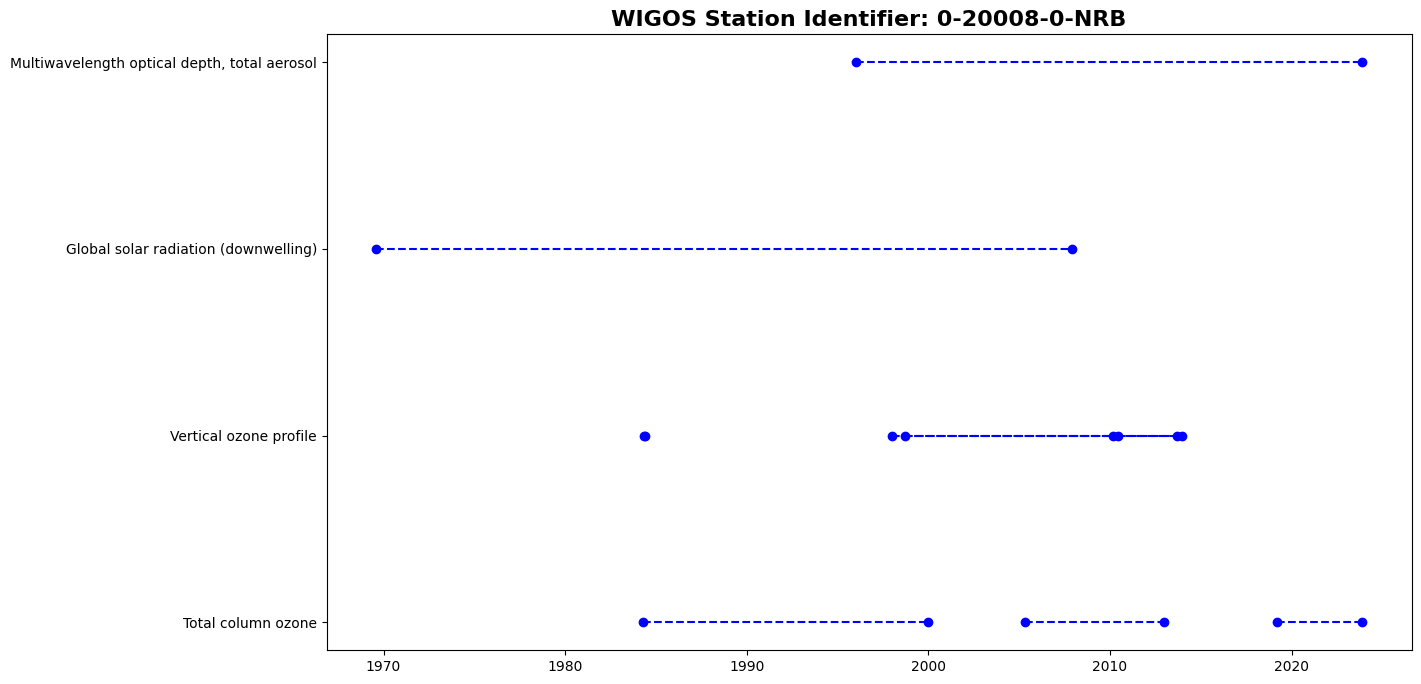

In [29]:
plot_deployments_station(WIGOS_ID="0-20008-0-NRB")

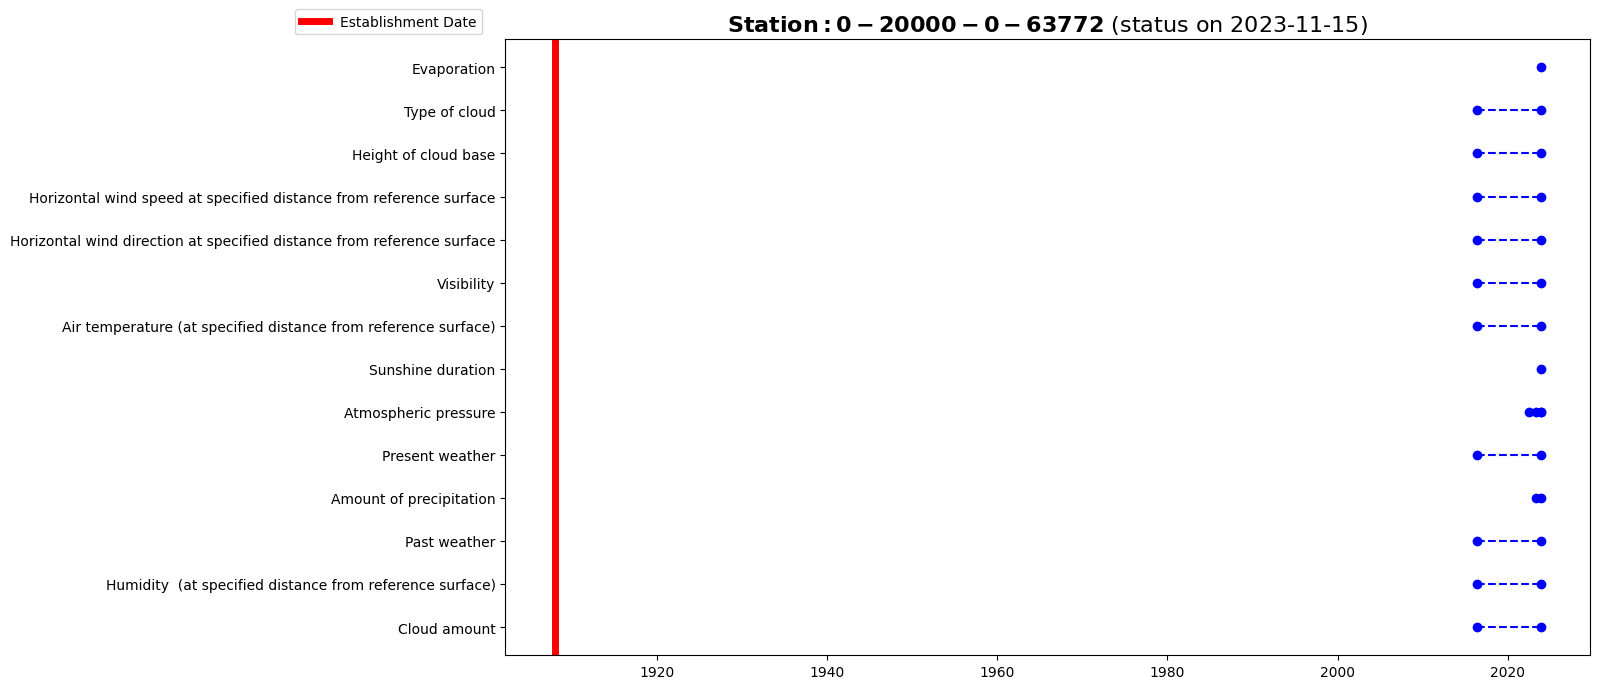

In [276]:
# include establishment date

plt.style.use('default')
fig, axes = plt.subplots(1,1, figsize=(14,8))

variables = variables_u

for var in range(0,len(variables)):
    df_var = df_station[df_station["variable"]==str(variables[var])]

    x_values = [pd.to_datetime(df_var["beginPosition"]), pd.to_datetime(df_var["endPosition"])]
    # print(x_values)
    plt.plot(x_values, [var,var], 'bo', linestyle="--")
    

# line for establishment date
est_date = [pd.to_datetime(df_var["dateEstablished"])]
plt.axvline(x=est_date, c="red", linewidth=5, label= "Establishment Date")

# print(variables)
names = []
for var in range(0,len(variables)):
    variable_df = df_station[df_station["variable"]==str(variables[var])]
    name = variable_df.iloc[0]["variables_names"]
    # print(name)
    names.append(name)
n = range(0,len(names))
plt.yticks(n,names)

# title
# from matplotlib import rc
# rc('text', usetex=True)
# fontsize=16, fontweight="bold"
plt.title(r'$\bf{Station: ' + id+'}$' + ' (status on ' + pd.Timestamp.today().strftime("%Y-%m-%d") + ')', fontsize=16)

# legend
plt.legend(loc="upper left", fontsize=10, scatterpoints=25, bbox_to_anchor=(-0.2, 1.06))


# save figure
fig.savefig(os.getcwd()+"/Plots/Deployments_"+id+"_withEstablishmentDate.jpeg", bbox_inches='tight')